In [1]:
#import all of needs library
import tensorflow as tf
import pandas as pd
import numpy as np
#BayesianOptimization library is from https://github.com/fmfn/BayesianOptimization
#This lib is well organized and author introduce it well
from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt
from matplotlib import gridspec
from random import randint
import datetime

In [2]:
# I download the kospi stock data from google finance.
# there are 'Date, Close, Open, High, Low, Volumn' data.
# I will expect 1 day future close stock price from close stock price using linear regression.
df=pd.read_csv(filepath_or_buffer='kospi.csv',header=0,index_col=0)
df=df.reset_index()
df.sort_index(ascending=False)
df['Close_1Lag']=df['Close'].shift(1)
df = df.dropna(axis=0,how='any')
close = df['Close'].as_matrix()
close = close.reshape(len(close),1)
close_lag = df['Close_1Lag'].as_matrix()
close_lag = close_lag.reshape(len(close_lag),1)

In [3]:
# make the normalization of close and 1-day future close stock price.
def MinMaxScaler(data):
    numerator = data - np.min(data, 0)  # data - axis 0인 min값.
    denominator = np.max(data, 0) - np.min(data, 0)  # min max 차이값
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)  # MaxMin폭 사이에 data가 얼마인가?!

close = MinMaxScaler(close)
close_lag = MinMaxScaler(close_lag)

tf.set_random_seed(777)  # for reproducibility
# split the dataset for training and testing.
def split_dataset(data,split_ratio=0.7):
    split_row = int(len(data)*split_ratio)
    train = data[:split_row]
    test = data[split_row:]
    return train,test

x_train,x_test = split_dataset(close,0.7)
y_train,y_test = split_dataset(close_lag,0.7)

In [17]:
# build the model for linear regression.
# It is just normal and simple linear regression.
def model(my_learning_rate):
    W = tf.Variable(tf.random_normal([1]), name='weight')
    b = tf.Variable(tf.random_normal([1]), name='bias')

    X = tf.placeholder(tf.float32, shape=[None,1])
    Y = tf.placeholder(tf.float32, shape=[None,1])

    # Our hypothesis XW+b
    hypothesis = X * W + b
    # cost/loss function
    cost = tf.reduce_mean(tf.square(hypothesis - Y))
    # Minimize
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=my_learning_rate)
    train = optimizer.minimize(cost)
    # Accuracy(R2)
    total_error = tf.reduce_sum(tf.square(tf.subtract(Y, tf.reduce_mean(Y))))
    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(Y, hypothesis)))
    R_squared = tf.subtract(tf.div(total_error, unexplained_error), 1.0)
    # Launch the graph in a session.
    sess = tf.Session()
    # Initializes global variables in the graph.
    sess.run(tf.global_variables_initializer())
    # Fit the line
    for step in range(100):
        cost_val, W_val, b_val, _ = sess.run([cost, W, b, train],feed_dict={X: x_train, Y: y_train})
    R_squared_val, W_val, b_val, _ = sess.run([R_squared, W, b, train],feed_dict={X: x_test, Y: y_test})
    return R_squared_val

In [18]:
# for display baysian optimization.
# please see the BayesianOptimization lib.
def posterior(bo, x, xmin=-2, xmax=10):
    xmin, xmax = -2, 10
    bo.gp.fit(bo.X, bo.Y)
    mu, sigma = bo.gp.predict(x, return_std=True)
    return mu, sigma

def plot_gp(bo, x):
    fig = plt.figure(figsize=(16, 10))
    fig.suptitle('Gaussian Process and Utility Function After {} Steps'.format(len(bo.X)), fontdict={'size': 30})

    gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])
    axis = plt.subplot(gs[0])
    acq = plt.subplot(gs[1])
    mu, sigma = posterior(bo, x)
    # axis.plot(x, y, linewidth=3, label='Target')
    axis.plot(bo.X.flatten(), bo.Y, 'D', markersize=8, label=u'Observations', color='r')
    axis.plot(x, mu, '--', color='k', label='Prediction')
    axis.fill(np.concatenate([x, x[::-1]]),np.concatenate([mu - 1.9600 * sigma, (mu + 1.9600 * sigma)[::-1]]),alpha=.6, fc='c', ec='None', label='95% confidence interval')

    axis.set_xlim((0.0, 0.9))
    axis.set_ylim((None, None))
    axis.set_ylabel('f(x)', fontdict={'size': 20})
    axis.set_xlabel('x', fontdict={'size': 20})

    utility = bo.util.utility(x, bo.gp, 0)
    acq.plot(x, utility, label='Utility Function', color='purple')
    acq.plot(x[np.argmax(utility)], np.max(utility), '*', markersize=15,label=u'Next Best Guess', markerfacecolor='gold', markeredgecolor='k', markeredgewidth=1)
    
    acq.set_xlim((0.0, 0.9))
    acq.set_ylim((0, np.max(utility) + 0.5))
    acq.set_ylabel('Utility', fontdict={'size': 20})
    acq.set_xlabel('x', fontdict={'size': 20})

    axis.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)
    acq.legend(loc=2, bbox_to_anchor=(1.01, 1), borderaxespad=0.)

Initialization
--------------------------------------------------
 Step |   Time |      Value |   my_learning_rate | 
    1 | 00m00s |    2.76230 |             0.4563 | 
    2 | 00m00s |    2.75867 |             0.4146 | 
Bayesian Optimization
--------------------------------------------------
 Step |   Time |      Value |   my_learning_rate | 
Bayesian Optimization
--------------------------------------------------
 Step |   Time |      Value |   my_learning_rate | 
    3 | 00m01s |   -1.00000 |             0.9000 | 
    4 | 00m00s |   -0.50077 |             0.1731 | 
    5 | 00m00s |    2.77309 |             0.5954 | 
    6 | 00m00s |    2.77500 |             0.6962 | 
    7 | 00m00s |    2.51909 |             0.3281 | 
    8 | 00m00s |    2.77584 |             0.5277 | 
    9 | 00m00s |    2.77472 |             0.6492 | 
   10 | 00m01s |   -0.31248 |             0.0010 | 
   11 | 00m01s |    2.77371 |             0.5319 | 
   12 | 00m01s |    2.77574 |             0.7555 | 
   13 | 

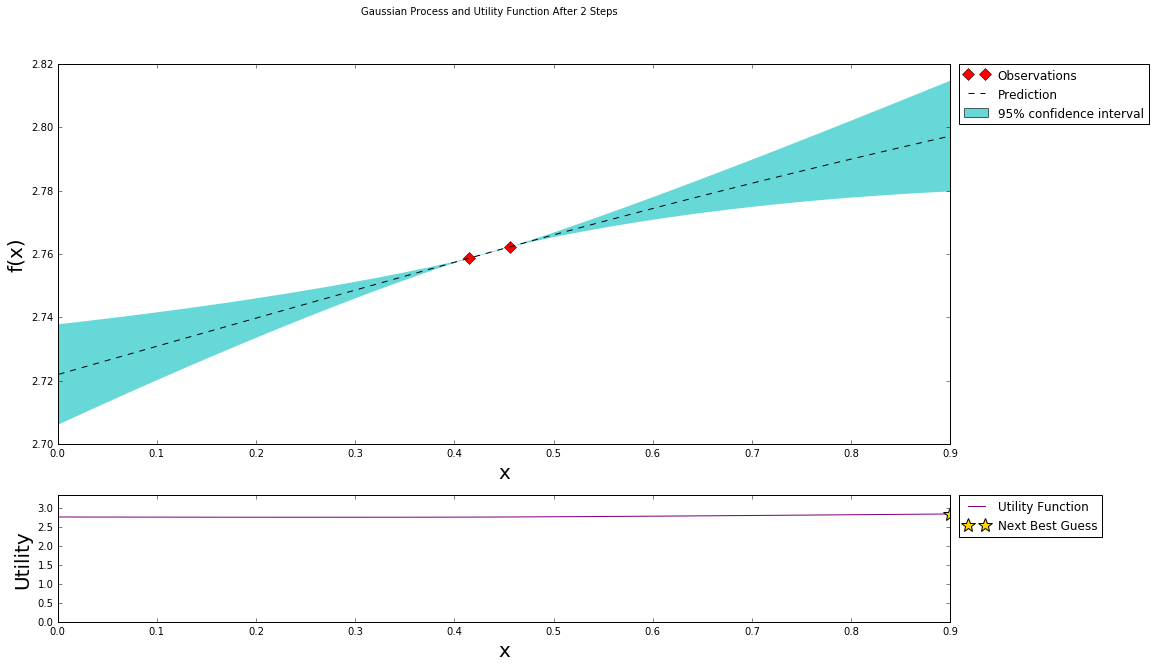

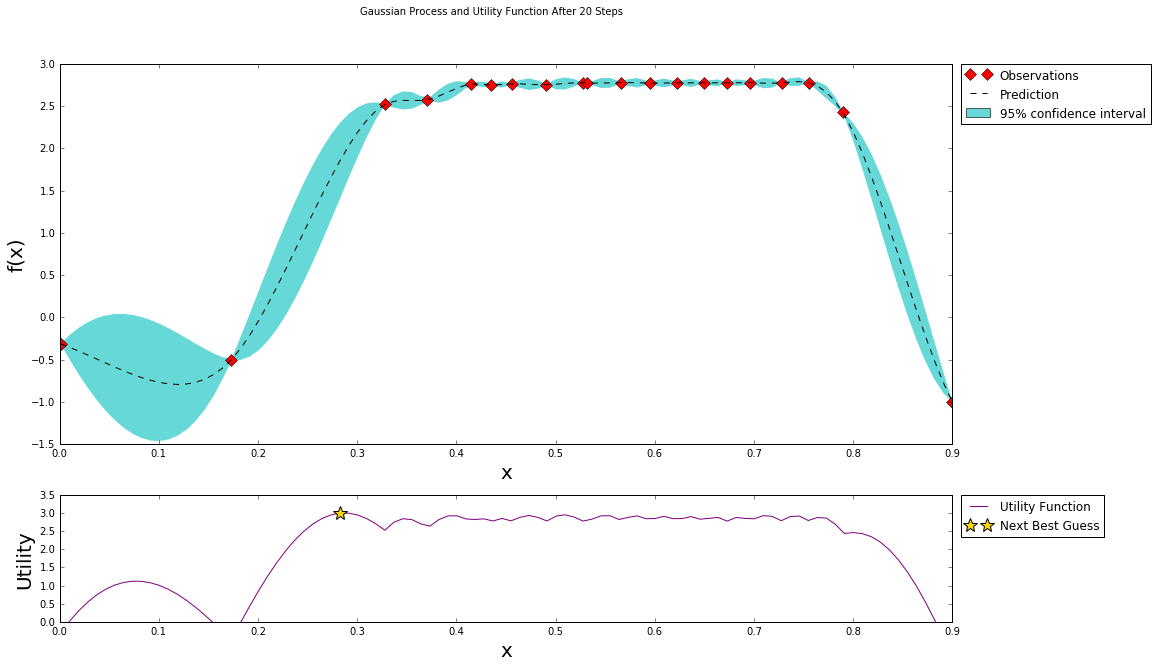

In [19]:
# do it BayesianOptimization.
x = np.linspace(0.001, 0.9, 100).reshape(-1, 1)
start_time = datetime.datetime.now()
bo = BayesianOptimization(model,{'my_learning_rate':(0.001,0.9)})
bo.maximize(init_points=2, n_iter=0, acq='ucb', kappa=5)
plot_gp(bo,x)
bo.maximize(init_points=0, n_iter=18, kappa=5)
plot_gp(bo,x)
end_time = datetime.datetime.now()
print(bo.res['max'])
print('tack time : %s'%(end_time-start_time))

In [8]:
# build the linear regression model
# for test grid search and random search
def model_manual(my_learning_rate):
    W = tf.Variable(tf.random_normal([1]), name='weight')
    b = tf.Variable(tf.random_normal([1]), name='bias')

    X = tf.placeholder(tf.float32, shape=[None,1])
    Y = tf.placeholder(tf.float32, shape=[None,1])

    # Our hypothesis XW+b
    hypothesis = X * W + b
    # cost/loss function
    cost = tf.reduce_mean(tf.square(hypothesis - Y))
    # Minimize
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=my_learning_rate)
    train = optimizer.minimize(cost)
    # Accuracy
    total_error = tf.reduce_sum(tf.square(tf.subtract(Y, tf.reduce_mean(Y))))
    unexplained_error = tf.reduce_sum(tf.square(tf.subtract(Y, hypothesis)))
    R_squared = tf.subtract(tf.div(total_error, unexplained_error), 1.0)
    # Launch the graph in a session.
    sess = tf.Session()
    # Initializes global variables in the graph.
    sess.run(tf.global_variables_initializer())
    # Fit the line
    for step in range(100):
        cost_val, W_val, b_val, _ = sess.run([cost, W, b, train],feed_dict={X: x_train, Y: y_train})
    R_squared_val, W_val, b_val, _ = sess.run([R_squared, W, b, train],feed_dict={X: x_test, Y: y_test})
    tf.reset_default_graph()
    return R_squared_val, cost_val, W_val, b_val

best {score : 2.93096}, {learning_rate : [ 0.7910303]}, {cost : 0.00061463}, {Weight : [ 0.99665344]}, {bais : [ 0.00102032]}
tack time : 0:00:18.338227


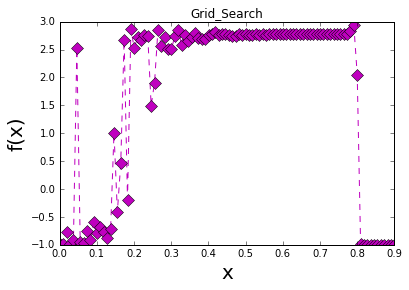

In [9]:
# start grid search.
grid_best_score = 0
grid_scores=[]
start_time = datetime.datetime.now()
for learning_rate in x:
    score,cost,W,b = model_manual(my_learning_rate=learning_rate[0])
    grid_scores.append(score)
    if score > grid_best_score:
        grid_best_score = score
        grid_best_cost = cost
        grid_best_W = W
        grid_best_b = b
        best_learning_rate = learning_rate
end_time = datetime.datetime.now()
print('best {score : %s}, {learning_rate : %s}, {cost : %s}, {Weight : %s}, {bais : %s}'%(grid_best_score,best_learning_rate,grid_best_cost,grid_best_W,grid_best_b))
print('tack time : %s'%(end_time-start_time))
plt.title('Grid_Search')
plt.plot(x,grid_scores,'D--', markersize=8, label=u'Grid_Search', color='m')
plt.xlabel('x', fontdict={'size': 20})
plt.ylabel('f(x)', fontdict={'size': 20})

best {score : 2.93096}, {learning_rate : [ 0.7910303]}, {cost : 0.000585742}, {Weight : [ 0.99788147]}, {bais : [ 0.00345646]}
tack time : 0:00:17.394867


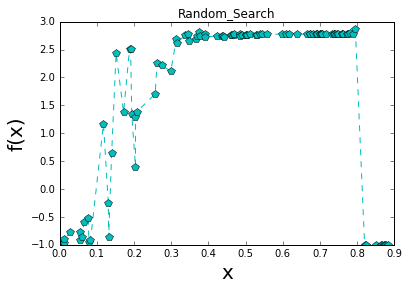

In [11]:
# start random search.
random_best_score = 0
random_scores=[]
learning_rates=[]
start_time = datetime.datetime.now()
for i in range(100):
    learning_rate = randint(1, 900)*0.001
    score, cost, W, b = model_manual(my_learning_rate=learning_rate)
    learning_rates.append(learning_rate)
    random_scores.append(score)
    if score > random_best_score:
        random_best_score = score
        grid_best_cost = cost
        grid_best_W = W
        grid_best_b = b
        random_learning_rate = learning_rate
end_time = datetime.datetime.now()
print('best {score : %s}, {learning_rate : %s}, {cost : %s}, {Weight : %s}, {bais : %s}'%(grid_best_score,best_learning_rate,grid_best_cost,grid_best_W,grid_best_b))
print('tack time : %s'%(end_time-start_time))
random_result = pd.DataFrame(index=learning_rates,data=random_scores)
random_result = random_result.sort_index()
plt.title('Random_Search')
plt.plot(random_result,'p--', markersize=8, label=u'Random_Search', color='c')
plt.xlabel('x', fontdict={'size': 20})
plt.ylabel('f(x)', fontdict={'size': 20})

In [ ]:
# conclusion
# the result time spend : baysian optimization > grid > random
# this test is just simply 100 times for grid and random search.
# if the parameter would be 2,3 or 4 much than 5, the time will increase dramatically.

#perfomance
#grid search - learning_rate : 0.7910303 , perfomance : 2.93096
#random search - learning_rate : 0.7910303 , perfomance : 2.93096
#baysian optimization - learning_rate: 0.5664 , perfomance : 2.7775552
# the baysian optimization result is not the best. see the performance 2.77 and 2.93.
# the baysian optimization iteration is just 20 but the grid and random is 100 times.

# as a result, for complex ML model, the baysian optimization is good but for simple, is not.
# for simple ML model, Let's use the random search.